In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Loading and preprocessing Dataset

In [6]:
df = pd.read_csv("data/SeoulBikeData.csv")
df = df.drop(["Date", "Holiday", "Seasons"], axis=1)
cols = [
    "bike_count", "hour", "temp",
    "humidity","wind", "visibility",
    "dew_pt_temp", "radiation", "rain",
    "snow", "functional",
]
df.columns = cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop("hour", axis=1)
df = df.drop(["wind", "visibility", "functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Train, Test, Valid Split

In [7]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

def get_xy(dataframe: pd.DataFrame, y_label, x_labels=None):
    dataframe = dataframe.copy()
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

print(train.shape)
print(valid.shape)
print(test.shape)

(219, 7)
(73, 7)
(73, 7)


## Multiple Regression with Neural Network

In [8]:
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])
print(X_train_all.shape)
print(y_train_all.shape)

(219, 6)
(219, 1)


In [9]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6, ), axis=-1)
all_normalizer.adapt(X_train_all)

2023-09-11 14:45:40.260280: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
)

In [11]:
history = nn_model.fit(
    X_train_all, y_train_all,
    epochs=100,
    validation_data=(X_valid_all, y_valid_all),
)

Epoch 1/100
7/7 [==============================] - 1s 88ms/step - loss: 619703.5000 - val_loss: 779070.1875
Epoch 2/100
7/7 [==============================] - 0s 53ms/step - loss: 619435.6875 - val_loss: 778746.4375
Epoch 3/100
7/7 [==============================] - 0s 53ms/step - loss: 619142.3125 - val_loss: 778379.0625
Epoch 4/100
7/7 [==============================] - 0s 32ms/step - loss: 618792.5625 - val_loss: 777951.9375
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 618372.1875 - val_loss: 777436.3750
Epoch 6/100
7/7 [==============================] - 0s 45ms/step - loss: 617861.6875 - val_loss: 776796.5000
Epoch 7/100
7/7 [==============================] - 0s 34ms/step - loss: 617250.5000 - val_loss: 776005.5000
Epoch 8/100
7/7 [==============================] - 0s 23ms/step - loss: 616498.1875 - val_loss: 775052.6875
Epoch 9/100
7/7 [==============================] - 0s 49ms/step - loss: 615618.0625 - val_loss: 773905.5625
Epoch 10/100
7/7 [==========

In [12]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

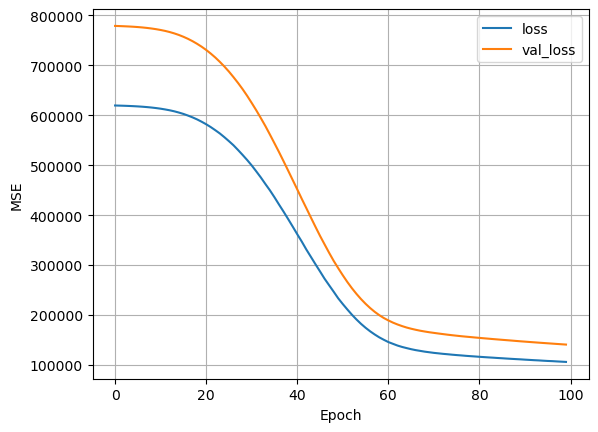

In [13]:
plot_loss(history)

In [ ]:
y_pred = nn_model.predict(X_test_all)
y_pred

## Plot the predicted vs test values

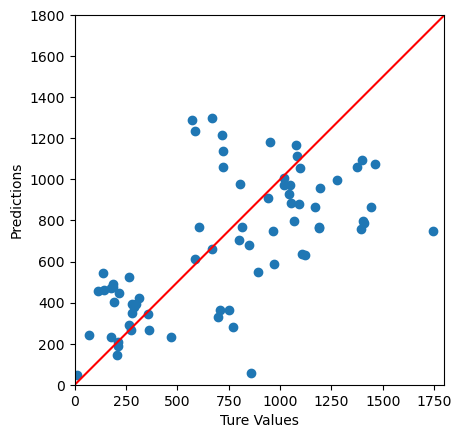

In [16]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred, label="NN Preds")
plt.xlabel("Ture Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, c="red")
plt.show()